# Шавель 853501 Лабораторная работа № 2

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    LEAVE = 3
    

class Simulator:
    
    
    def __init__(self, channels_cnt, queue_size, rq_intensity, service_intensity, leave_intensity):
        self.channels_cnt = channels_cnt
        self.queue_size = queue_size
        self.rq_intensity = rq_intensity
        self.service_intensity = service_intensity
        self.leave_intensity = leave_intensity
    
    
    def get_product(self, limit):
        prod = 1
        beta = self.leave_intensity / self.service_intensity
        for l in range(1, limit + 1):
            prod *= self.channels_cnt + l * beta
        return prod
    
    
    def theoretical_probs(self):
        ro = self.rq_intensity / self.service_intensity
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        for i in range(self.channels_cnt + 1):
            state_probs[0] += (ro ** i) / math.factorial(i)
            
        sm = 0
        for i in range(1, self.queue_size + 1):
            sm += (ro ** i) / self.get_product(i)
        state_probs[0] += (ro ** self.channels_cnt) * sm / math.factorial(self.channels_cnt)
        state_probs[0] = state_probs[0] ** (-1)
        for i in range(1, self.channels_cnt + 1):
            state_probs[i] = state_probs[0] * (ro ** i) / math.factorial(i)
        for i in range(1, self.queue_size + 1):
            prod = self.get_product(i)
            state_probs[self.channels_cnt + i] = state_probs[self.channels_cnt] * (ro ** i) / prod
        return state_probs
    
    
    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + sample(self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), 
                                     Action.LEAVE, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + sample(self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
            
    
    def leave(self, rq_id):
        if self.current_queue.count(rq_id):
            self.current_queue.remove(rq_id)
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
        elif action == Action.LEAVE:
            self.leave(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), Action.LEAVE, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time / self.total_time;
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time / self.total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        ro = self.rq_intensity / self.service_intensity
        features = dict()
        p_reject = state_probs[self.channels_cnt] * (ro ** self.queue_size) / self.get_product(self.queue_size)
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        avg_t_smo = avg_t_queue + Q / self.service_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_smo, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        data = {'Теор. вероятности состояний': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в СМО',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели':theor_features, 'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.045205,0.045132
1,0.150682,0.145416
2,0.251137,0.247572
3,0.244161,0.245260
4,0.167562,0.174433
5,0.088858,0.088035
6,0.038396,0.038830
7,0.013998,0.015322


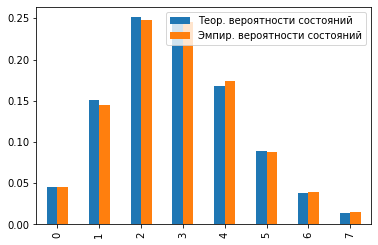

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.328667,0.328733
Вероятность отказа,0.013998,0.013800
Среднее количество заявок в СМО,2.828343,2.854481
Среднее количество заявок в очереди,1.069435,1.090160
Среднее время нахождения заявки в СМО,13.068320,13.132485
Среднее время нахождения заявки в очереди,3.208304,3.270481
Среднее количество используемых каналов,1.758908,1.764320


In [114]:
sim = Simulator(channels_cnt=2, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/7)
sim.full_compare()

Далее иследуем СМО при различных значениях параметров

При увеличении кол-ва каналов СМО среднее количество заявок в очереди уменьшается:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.037323,0.035028
1,0.124411,0.124497
2,0.207352,0.209552
3,0.230391,0.232006
4,0.191992,0.193155
5,0.117890,0.116526
6,0.057308,0.056676
7,0.023055,0.022296
8,0.007911,0.007985
9,0.002367,0.002278


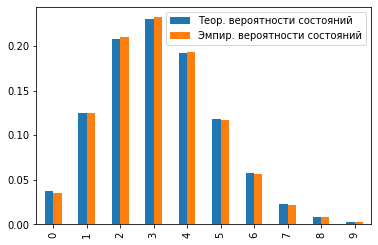

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.332544,0.332540
Вероятность отказа,0.002367,0.002381
Среднее количество заявок в СМО,3.177525,3.175387
Среднее количество заявок в очереди,0.345147,0.340101
Среднее время нахождения заявки в СМО,11.011774,10.996494
Среднее время нахождения заявки в очереди,1.035440,1.020302
Среднее количество используемых каналов,2.832378,2.835286


In [115]:
sim = Simulator(channels_cnt=4, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/7)
sim.full_compare()

При увеличении ограничения на время ожидания в очереди среднее количество заявок в очереди увеличивается:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.012098,0.011529
1,0.040328,0.041176
2,0.067214,0.063518
3,0.101839,0.101324
4,0.141443,0.140523
5,0.181337,0.181015
6,0.215877,0.216480
7,0.239864,0.244434


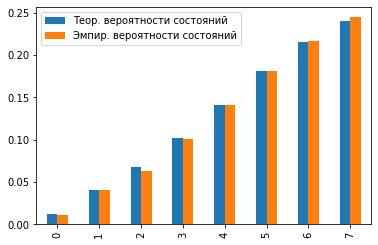

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.253379,0.257774
Вероятность отказа,0.239864,0.226677
Среднее количество заявок в СМО,4.927038,4.949273
Среднее количество заявок в очереди,2.991563,3.013507
Среднее время нахождения заявки в СМО,16.576053,16.773756
Среднее время нахождения заявки в очереди,8.974690,9.040521
Среднее количество используемых каналов,1.935475,1.935766


In [116]:
sim = Simulator(channels_cnt=2, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении очереди вероятность отказа уменьшается:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.008094,0.010021
1,0.026979,0.031994
2,0.044964,0.052772
3,0.068128,0.071888
4,0.094622,0.098480
5,0.121310,0.116860
6,0.144417,0.135356
7,0.160464,0.151716
8,0.167150,0.164167
9,0.163872,0.166747


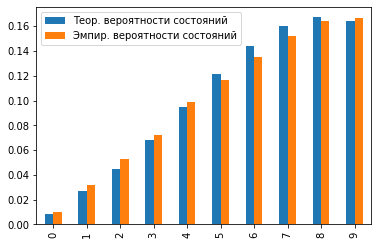

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.278709,0.269224
Вероятность отказа,0.163872,0.192327
Среднее количество заявок в СМО,6.108128,6.019624
Среднее количество заявок в очереди,4.151294,4.071659
Среднее время нахождения заявки в СМО,20.815159,20.291703
Среднее время нахождения заявки в очереди,12.453881,12.214977
Среднее количество используемых каналов,1.956834,1.947965


In [117]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении интенсивности потока заявок вероятность отказа увеличивается, как и среднее количество заявок в очереди

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.000483,0.000553
1,0.002416,0.002991
2,0.006040,0.007146
3,0.013727,0.014743
4,0.028598,0.029068
5,0.054996,0.057558
6,0.098208,0.097725
7,0.163680,0.161766
8,0.255750,0.259566
9,0.376102,0.368885


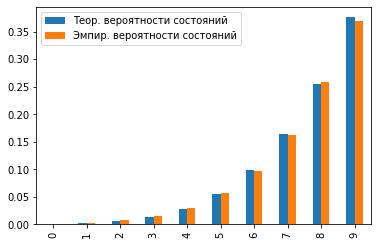

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.311949,0.277526
Вероятность отказа,0.376102,0.444948
Среднее количество заявок в СМО,7.610973,7.580776
Среднее количество заявок в очереди,5.614355,5.584873
Среднее время нахождения заявки в СМО,17.467688,16.720271
Среднее время нахождения заявки в очереди,11.228711,11.169747
Среднее количество используемых каналов,1.996618,1.995903


In [118]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении интенсивности потока обслуживания вероятность отказа уменьшается, как и среднее количество заявок в очереди

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.165477,0.168220
1,0.248215,0.250263
2,0.186162,0.185275
3,0.135555,0.132858
4,0.095911,0.094565
5,0.065994,0.065303
6,0.044192,0.043700
7,0.028821,0.028336
8,0.018319,0.020297
9,0.011354,0.011183


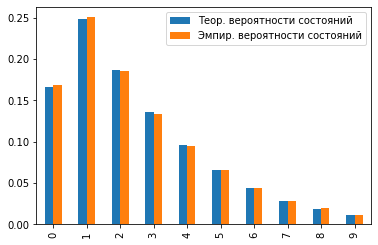

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.494323,0.494350
Вероятность отказа,0.011354,0.011300
Среднее количество заявок в СМО,2.456457,2.447737
Среднее количество заявок в очереди,1.035626,1.034439
Среднее время нахождения заявки в СМО,5.037189,5.034977
Среднее время нахождения заявки в очереди,2.071252,2.068879
Среднее количество используемых каналов,1.420831,1.413298


In [119]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()

При уменьшении интенсивности потока заявок вероятность отказа уменьшается, как и среднее количество заявок в очереди:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.539718,0.542948
1,0.323831,0.325188
2,0.097149,0.094365
3,0.028296,0.027181
4,0.008008,0.007766
5,0.002204,0.002093
6,0.000590,0.000423
7,0.000154,0.000035
8,0.000039,0.000000
9,0.000010,0.000000


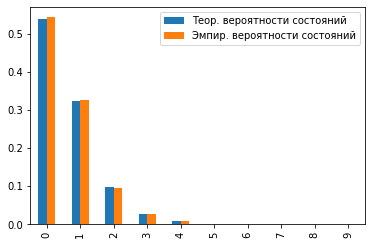

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.199998,0.199998
Вероятность отказа,0.000010,0.000009
Среднее количество заявок в СМО,0.651092,0.639778
Среднее количество заявок в очереди,0.054359,0.050862
Среднее время нахождения заявки в СМО,3.271767,3.254284
Среднее время нахождения заявки в очереди,0.271797,0.254312
Среднее количество используемых каналов,0.596733,0.588916


In [120]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/5, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()

При наличии только 1-го канала эти цифры наоборот возрастают:

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.031314,0.031461
1,0.046971,0.047562
2,0.066468,0.067827
3,0.089020,0.088122
4,0.113161,0.111818
5,0.136888,0.134622
6,0.157948,0.161754
7,0.174207,0.177558
8,0.184022,0.179276


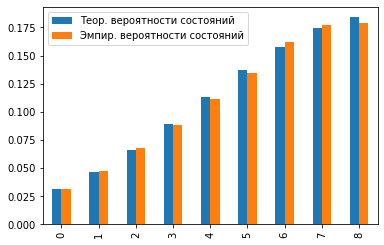

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.407989,0.406831
Вероятность отказа,0.184022,0.186338
Среднее количество заявок в СМО,5.223370,5.215603
Среднее количество заявок в очереди,4.254684,4.247063
Среднее время нахождения заявки в СМО,10.957301,10.935112
Среднее время нахождения заявки в очереди,8.509367,8.494127
Среднее количество используемых каналов,0.968686,0.968539


In [123]:
sim = Simulator(channels_cnt=1, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()